In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from skimage.io import imread
%matplotlib inline

模板匹配

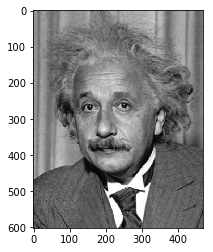

In [2]:
img=cv2.imread('./imgs/einstein_org.png')
plt.imshow(img)
plt.show()

方案1： 直接用爱因斯坦的眼睛局部图像去卷积原图¶

In [4]:
eye=cv2.imread('./imgs/einstein_eye.png')
filteredImg1=cv2.filter2D(img.astype(np.float64), -1, eye)
filteredImg1=255 * (filteredImg1-filteredImg1.min())/(filteredImg1.max()-filteredImg1.min())
filteredImg1=filteredImg1.astype(np.uint8)

In [5]:
def showFilterResult(img,eye,filteredResult,suptitle):
    plt.figure(figsize=(15,5))
    plt.suptitle(suptitle, fontsize=14)
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.subplot(1,3,2)
    plt.imshow(eye)
    plt.title("Filter Kernel")
    plt.subplot(1,3,3)
    plt.imshow(filteredResult, cmap="gray")
    plt.title("Filter Result")
    plt.show()

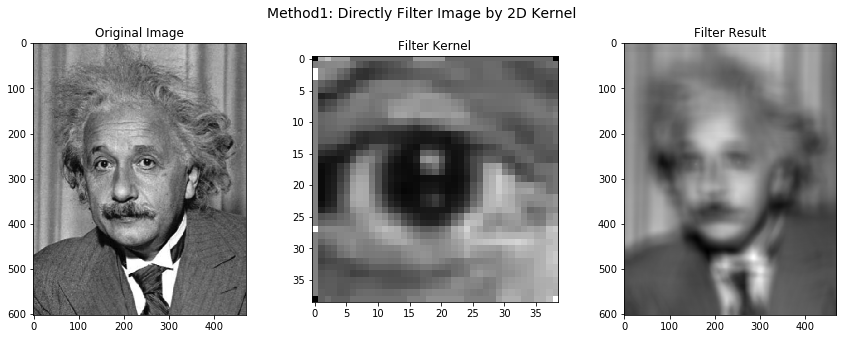

In [6]:
showFilterResult(img,eye,filteredImg1, "Method1: Directly Filter Image by 2D Kernel")

利用0均值模板去滤波

In [7]:
eye_0mean=eye-eye.mean()

filteredImg2=cv2.filter2D(img.astype(np.float64), -1, eye_0mean)
filteredImg2=255 * (filteredImg2-filteredImg2.min())/(filteredImg2.max()-filteredImg2.min())
filteredImg2=filteredImg2.astype(np.uint8)
filteredImg2[filteredImg2<200]=0
filteredImg2=cv2.rectangle(filteredImg2,(120,230),(200,300),color=(255,0,0),thickness=2)
filteredImg2=cv2.rectangle(filteredImg2,(180,370),(400,570),color=(0,255,255),thickness=2)

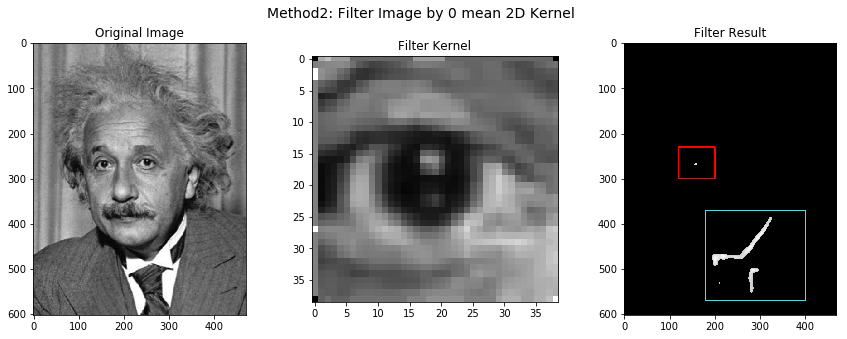

In [8]:
showFilterResult(img,eye,filteredImg2, "Method2: Filter Image by 0 mean 2D Kernel")

采用均方误差(SSD)

In [9]:
def filterSSD(img, kernel):
    filteredImg=cv2.matchTemplate(img.astype(np.float32), eye.astype(np.float32), method=cv2.TM_SQDIFF)
    filteredImg=255 * (filteredImg-filteredImg.min())/(filteredImg.max()-filteredImg.min())
    filteredImg=filteredImg.astype(np.uint8)
    filteredImg[filteredImg>0]=255
    filteredImg=255-filteredImg
    filteredImg=cv2.rectangle(filteredImg,(120,230),(200,300),color=(255,255,255),thickness=2)
    return filteredImg.astype(np.uint8)

filteredImg3 = filterSSD(img, eye)

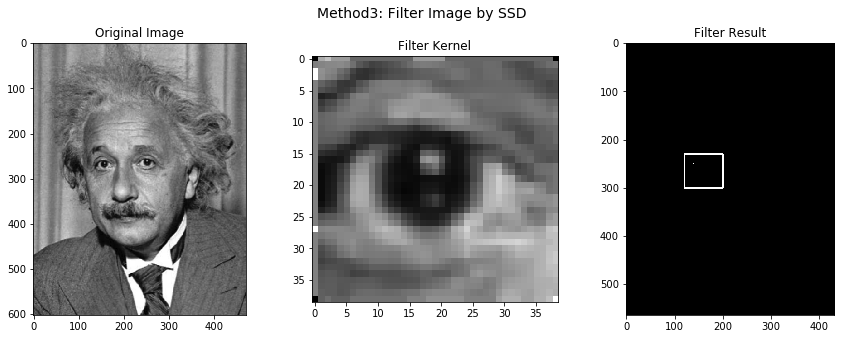

In [10]:
showFilterResult(img,eye,filteredImg3, "Method3: Filter Image by SSD")

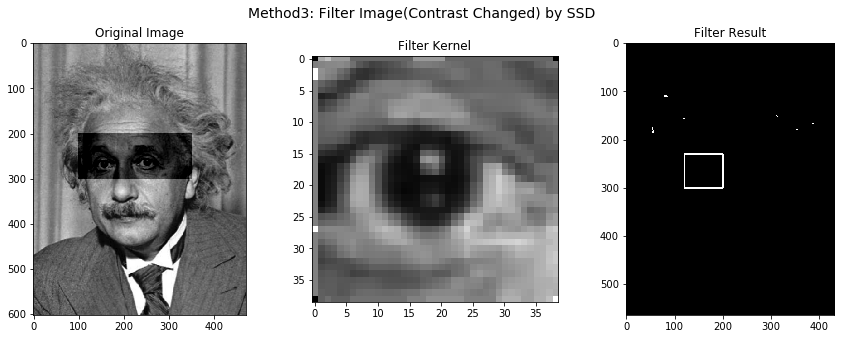

In [11]:
imgNoise=img.copy().astype(np.float32)
imgNoise[200:300,100:350]-=100
imgNoise[200:300,100:350][imgNoise[200:300,100:350]<0]=0
imgNoise=imgNoise.astype(np.uint8)

filteredImg32=filterSSD(imgNoise, eye)
showFilterResult(imgNoise,eye,filteredImg32, "Method3: Filter Image(Contrast Changed) by SSD")

采用归一化互相关系数(NCC)

In [13]:
def filterNCC(img, kernel, threshold):
    filteredImg=cv2.matchTemplate(img.astype(np.float32), eye.astype(np.float32), method=cv2.TM_CCOEFF_NORMED)
    filteredImg=255 * (filteredImg-filteredImg.min())/(filteredImg.max()-filteredImg.min())
    filteredImg[filteredImg<threshold]=0
    filteredImg=cv2.rectangle(filteredImg,(120,230),(200,300),color=(255,255,255),thickness=2)
    return filteredImg

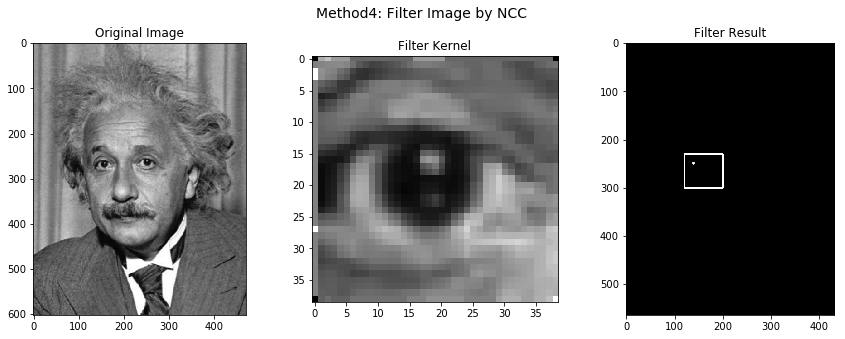

In [14]:
filteredImg4 = filterNCC(img, eye,200)
showFilterResult(img,eye,filteredImg4, "Method4: Filter Image by NCC")

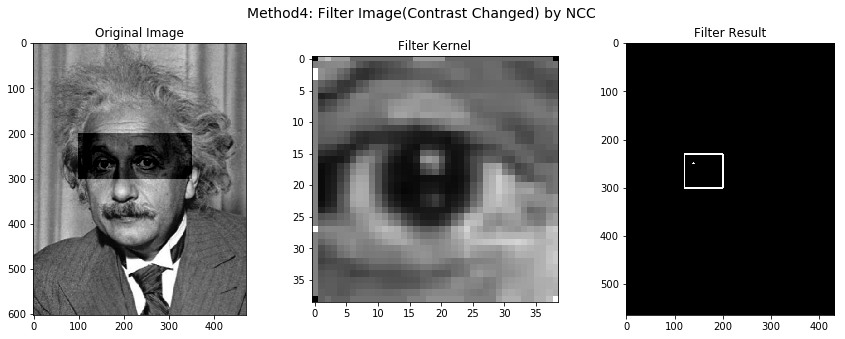

In [15]:
filteredImg42 = filterNCC(imgNoise, eye,220)
showFilterResult(imgNoise,eye,filteredImg42, "Method4: Filter Image(Contrast Changed) by NCC")

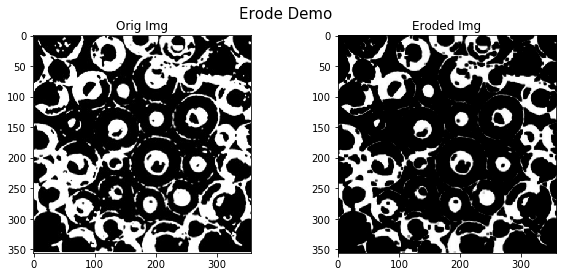

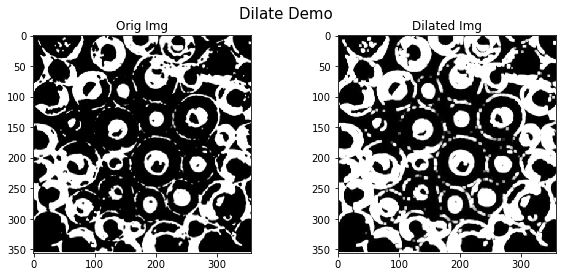

In [16]:
def compareImg(img1, img2, suptitle, title1, title2):
    plt.figure(figsize=(10,4))
    plt.suptitle(suptitle, fontsize=15)
    plt.subplot(1,2,1)
    plt.imshow(img1)
    plt.title(title1)
    plt.subplot(1,2,2)
    plt.imshow(img2)
    plt.title(title2)
    plt.show()
    
img=cv2.imread('./imgs/binary.jpg')
erodeImg=cv2.erode(img, np.array([]))
dilateImg=cv2.dilate(img, np.array([]))
compareImg(img, erodeImg, "Erode Demo", "Orig Img", "Eroded Img")
compareImg(img, dilateImg, "Dilate Demo", "Orig Img", "Dilated Img")

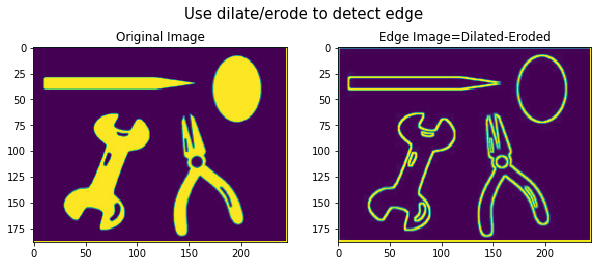

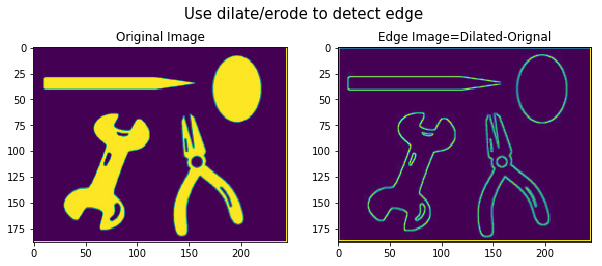

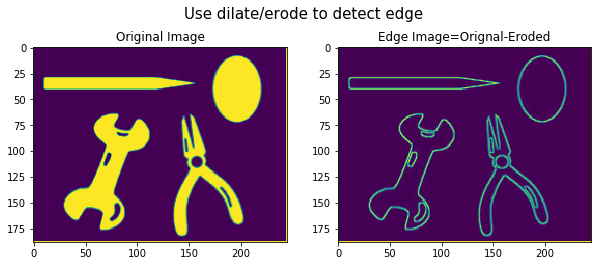

In [17]:
ftools=cv2.imread('./imgs/ftools.jpg', cv2.IMREAD_GRAYSCALE)
ftools_dilated=cv2.dilate(ftools, kernel=np.array([]))
ftools_eroded=cv2.erode(ftools, kernel=np.array([]))
edge1=ftools_dilated-ftools_eroded
edge2=ftools_dilated-ftools
edge3=ftools-ftools_eroded
compareImg(ftools, edge1, 'Use dilate/erode to detect edge', 'Original Image', 'Edge Image=Dilated-Eroded')
compareImg(ftools, edge2, 'Use dilate/erode to detect edge', 'Original Image', 'Edge Image=Dilated-Orignal')
compareImg(ftools, edge3, 'Use dilate/erode to detect edge', 'Original Image', 'Edge Image=Orignal-Eroded')

双边滤波 vs 高斯滤波 vs 非局部均值滤波

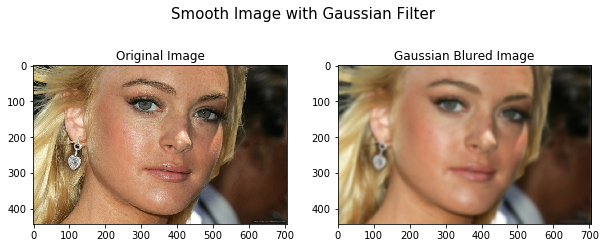

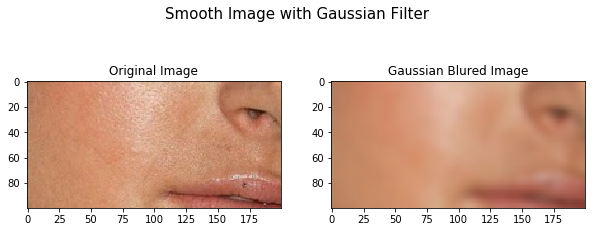

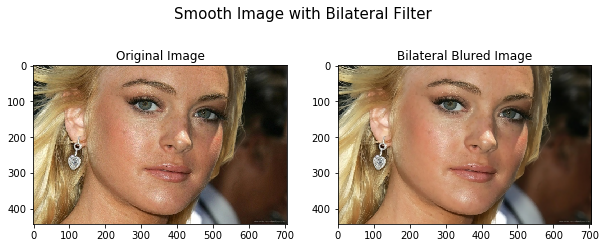

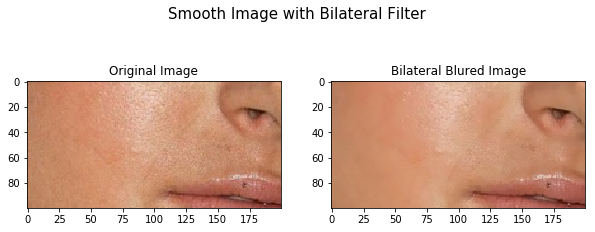

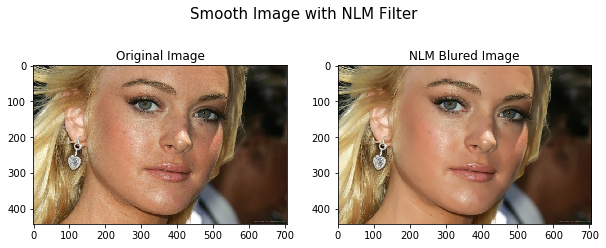

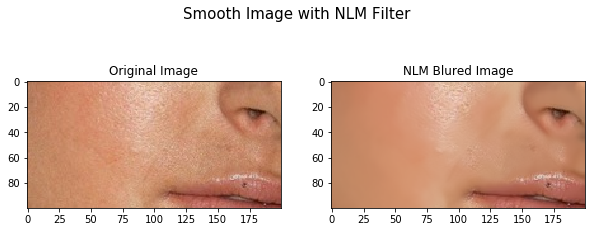

In [19]:
girl=cv2.imread('./imgs/girl.jpg')[:,:,2::-1]
girlGf=cv2.GaussianBlur(girl, (0,0), 3, 3)
girlBlf=cv2.bilateralFilter(girl,-1,20,3)
girlNlm=cv2.fastNlMeansDenoising(girl,h=5)
compareImg(girl, girlGf, 'Smooth Image with Gaussian Filter', 'Original Image', 'Gaussian Blured Image')
compareImg(girl[200:300,200:400], girlGf[200:300,200:400], 'Smooth Image with Gaussian Filter', 'Original Image', 'Gaussian Blured Image')
compareImg(girl, girlBlf, 'Smooth Image with Bilateral Filter', 'Original Image', 'Bilateral Blured Image')
compareImg(girl[200:300,200:400], girlBlf[200:300,200:400], 'Smooth Image with Bilateral Filter', 'Original Image', 'Bilateral Blured Image')
compareImg(girl, girlNlm, 'Smooth Image with NLM Filter', 'Original Image', 'NLM Blured Image')
compareImg(girl[200:300,200:400], girlNlm[200:300,200:400], 'Smooth Image with NLM Filter', 'Original Image', 'NLM Blured Image')